# Focus On Cuisines

## cleanup

In [43]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns 
import math 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
sys.path.append('../Functions')
import CleanUp as p



In [ ]:
filepath = '../Data/DM2425_ABCDEats_DATASET.csv'
# Load the raw data
raw_data = pd.read_csv(filepath)
df, columns_dict = p.cleanUp(raw_data)

-----------looking for incostisencies -----------
There are repeated values in the dataset
      customer_id customer_region  customer_age  vendor_count  product_count  \
20855  742ca068fc            8550          20.0             1              2   
20907  742ca068fc            8550          20.0             1              2   

       is_chain  first_order  last_order last_promo payment_method  ...  \
20855         0         35.0          35          -           CARD  ...   
20907         0         35.0          35          -           CARD  ...   

       HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  
20855      0      0      0      0      0      0      0      0      0      0  
20907      0      0      0      0      0      0      0      0      0      0  

[2 rows x 56 columns]
-----------identify the numerical columns -----------
primary_key is not numerical
-----------identify the non numerical columns -----------
primary_key is non numerical


In [4]:
df.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_20,HR_21,HR_22,HR_23,used_promo,delta_day_order,tot_value_cui,order_freq,value_freq,avg_order_value
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,0,0,0,0,True,2.0,28.88,2.500000,14.440,5.776
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,0,0,0,0,True,2.0,19.21,1.000000,9.605,9.605
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,...,0,0,0,0,True,2.0,9.20,1.000000,4.600,4.600
3,180c632ed8,4660,NaN,2,3,1,0.0,2,DELIVERY,DIGI,...,0,0,0,0,True,3.0,31.56,1.000000,10.520,10.520
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,No_Promo,DIGI,...,0,0,0,0,False,3.0,55.44,1.666667,18.480,11.088


### extract the necessary columns

In [ ]:
key = columns_dict.keys()
print(key)
new_features_list = columns_dict['new_features_list']
numerical_columns = columns_dict['numerical_columns']
CUI_col = columns_dict['CUI_col']
HR_col = columns_dict['HR_col']
DOW_col = columns_dict['DOW_col']

dict_keys(['non_numerical_columns', 'new_features_list', 'numerical_columns', 'CUI_col', 'HR_col', 'DOW_col'])


### find de value and the total value per cuisine

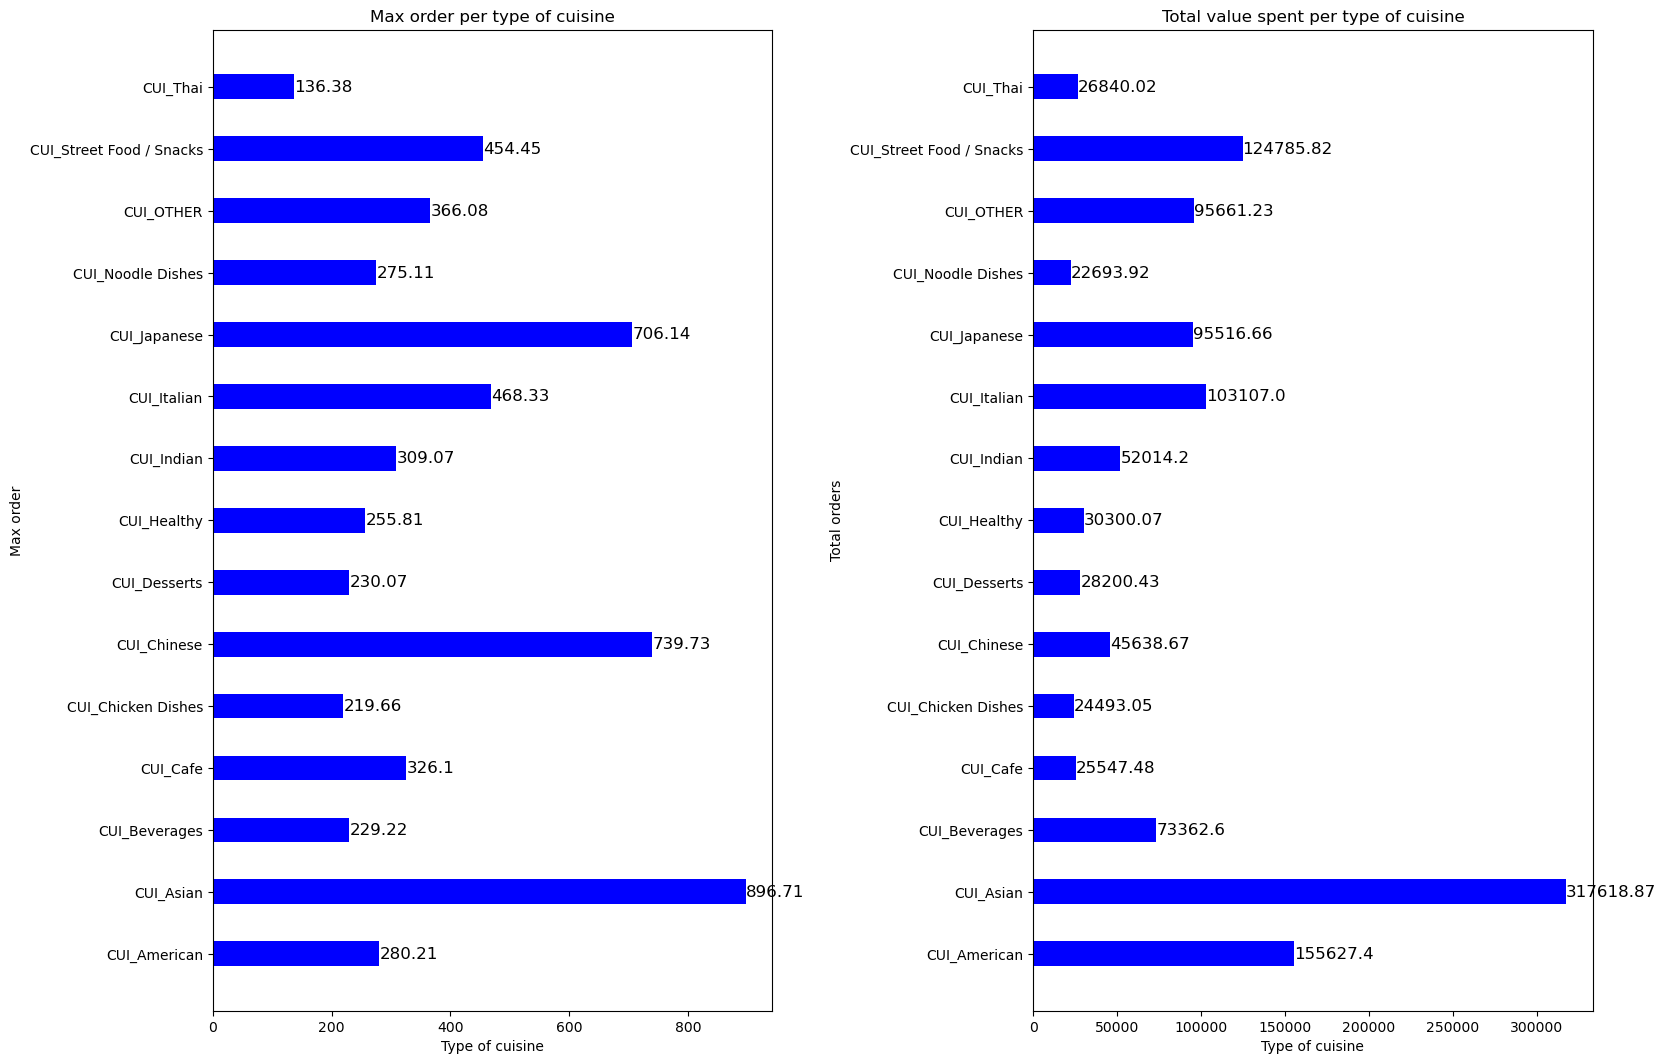

In [13]:
max_values = df[CUI_col].max()
sum_values = df[CUI_col].sum().round(2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 11))

axes[0].barh(max_values.index, max_values.values, color='blue', height=0.4)
axes[0].set_title('Max order per type of cuisine')
axes[0].set_xlabel('Type of cuisine')
axes[0].set_ylabel('Max order')
for i in range(len(max_values)):
    axes[0].text(max_values.values[i] + 1, i, str(max_values.values[i]), va='center', fontsize=12)

axes[1].barh(sum_values.index, sum_values.values, color='blue', height=0.4)
axes[1].set_title('Total value spent per type of cuisine')
axes[1].set_xlabel('Type of cuisine')
axes[1].set_ylabel('Total orders')
for i in range(len(sum_values)):
    axes[1].text(sum_values.values[i] + 1, i, str(sum_values.values[i]),va='center', fontsize=12)

plt.tight_layout(pad=2.0)
plt.show()

### count the zeroes of the CUI_col and plot the result
 as we can see the CUI_col feature exhibits sparse data characteristics, with 50% of the values being zero.

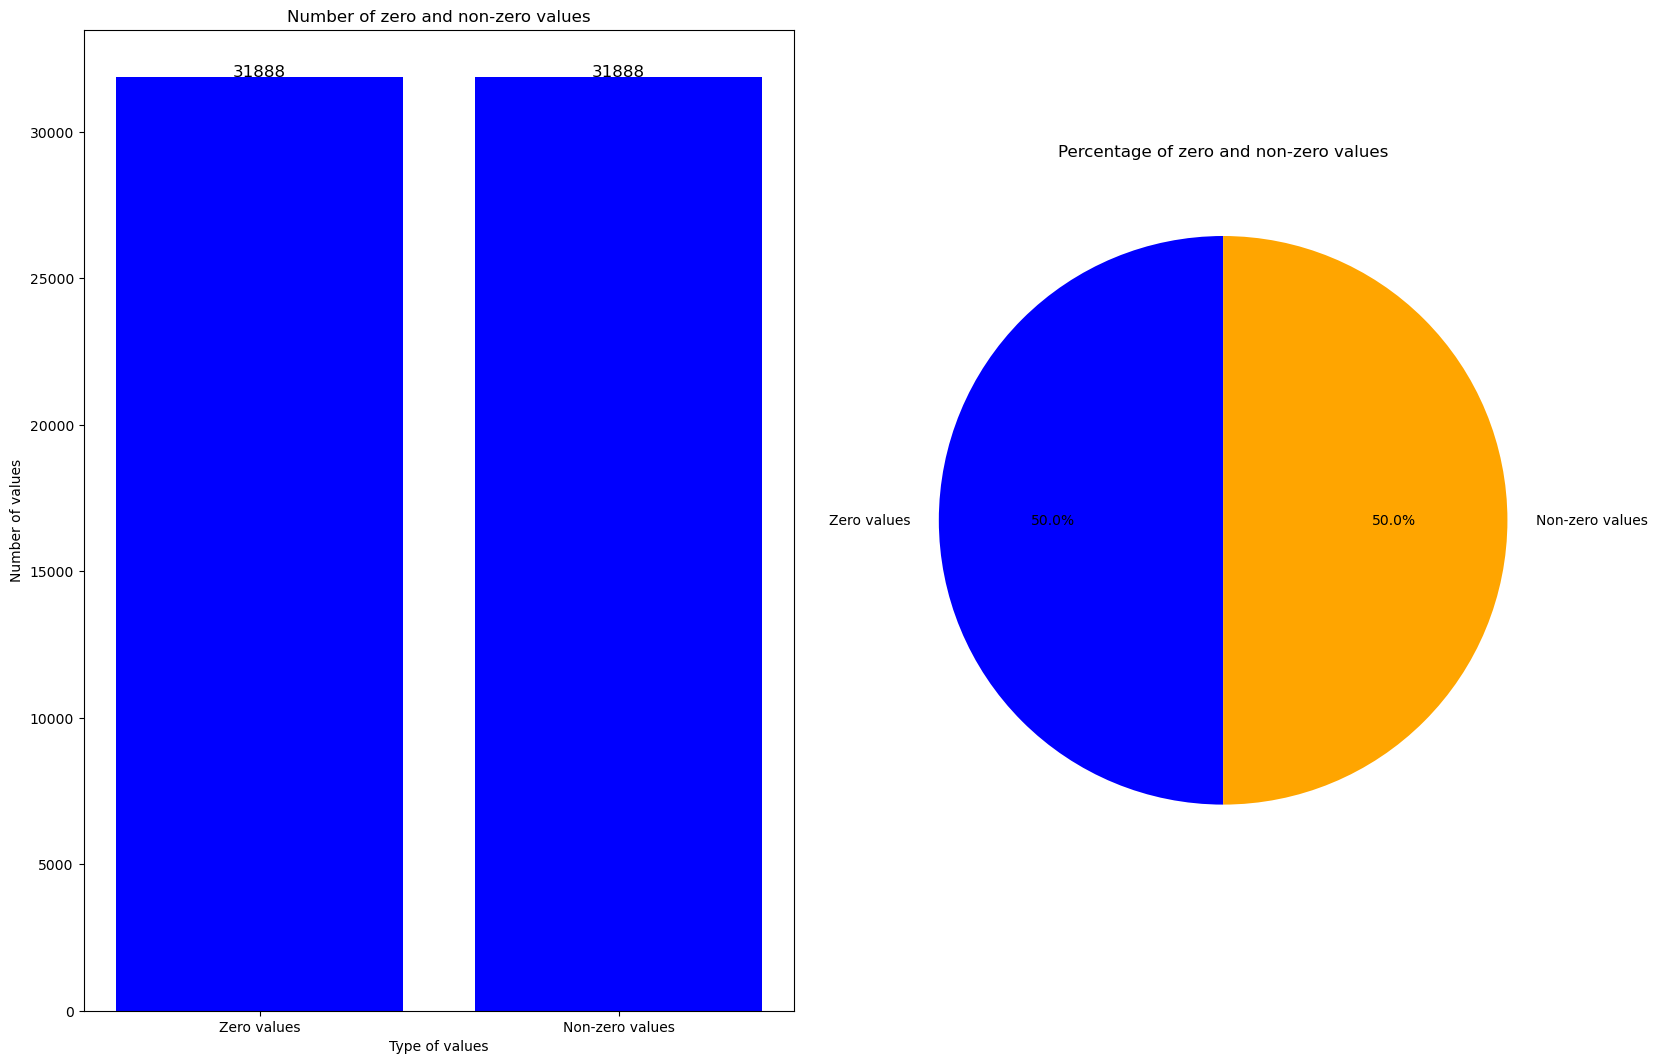

In [ ]:
zero_values = df[df[CUI_col] == 0].shape[0]
non_zero_values = df[df[CUI_col] != 0].shape[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 11))

axes[0].bar(['Zero values', 'Non-zero values'], [zero_values, non_zero_values], color='blue')
axes[0].set_title('Number of zero and non-zero values')
axes[0].set_xlabel('Type of values')
axes[0].set_ylabel('Number of values')
for i in range(2):
    axes[0].text(i, [zero_values, non_zero_values][i] + 1, [zero_values, non_zero_values][i], ha='center', fontsize=12)
    
axes[1].pie([zero_values, non_zero_values], labels=['Zero values', 'Non-zero values'], autopct='%1.1f%%', startangle=90, colors=['blue', 'orange'])
axes[1].set_title('Percentage of zero and non-zero values')

plt.tight_layout(pad=2.0)
plt.show()



### Let's coutn the ouliers

In [102]:
def count_outliers_for_columns(df, column_names):
    """
    Count the number of outliers for each specified column in a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_names (list): A list of column names to analyze.

    Returns:
    list: A list of tuples where each tuple contains the column name and the number of outliers.
    """
    outliers_count_list = []

    for column_name in column_names:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)

        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1

        # Define outliers as values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count the outliers
        outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
        outlier_count = outliers.shape[0]

        # Append the result as a tuple (column_name, outlier_count)
        x = "{p}%".format(p = int(outlier_count/df.shape[0]*1000)/10)
        outliers_count_list.append((column_name, outlier_count,x))

    return outliers_count_list

# Example usage:
# Assuming df is your DataFrame and you have a list of column names
outliers_counts = count_outliers_for_columns(df, CUI_col)

for col in outliers_counts:
    print(col)

('CUI_American', 3511, '11.0%')
('CUI_Asian', 3475, '10.8%')
('CUI_Beverages', 5435, '17.0%')
('CUI_Cafe', 1366, '4.2%')
('CUI_Chicken Dishes', 3248, '10.1%')
('CUI_Chinese', 3522, '11.0%')
('CUI_Desserts', 2016, '6.3%')
('CUI_Healthy', 2169, '6.8%')
('CUI_Indian', 3448, '10.8%')
('CUI_Italian', 6448, '20.2%')
('CUI_Japanese', 6301, '19.7%')
('CUI_Noodle Dishes', 2226, '6.9%')
('CUI_OTHER', 7041, '22.0%')
('CUI_Street Food / Snacks', 4249, '13.3%')
('CUI_Thai', 2378, '7.4%')


## Distribution of the cuisines by region 

In [103]:
regions = df["customer_region"].dropna().unique()

for region in regions:
    df_region = df[df["customer_region"] == region]
    total = df_region[CUI_col].sum(axis = 0)
    
    CUI_col_sum = df_region[CUI_col].sum(axis=0)
    CUI_col_sum.sort_values(ascending=True, inplace=True)
    CUI_cumperc = CUI_col_sum.cumsum()/CUI_col_sum.sum()
    CUI_cumperc = CUI_cumperc[CUI_cumperc > 0.30]
    CUI_cumperc = CUI_cumperc.index
    
    theta = total.index
    count = 1
    new_theta = []
    for t in theta:
        if t in CUI_cumperc:
            new_theta.append(t)
        else:
            new_theta.append(' ' * count)
            count += 1
    theta = new_theta    
    
    radar = pd.DataFrame(dict(r=total, theta=theta))
    fig = px.line_polar(radar, r='r', theta='theta', line_close=True)
    fig.update_layout(title=f'Region {region} Radar Chart')
    fig.show()

In [106]:
df_region = df.groupby('customer_region')[CUI_col].sum()

In [107]:
df_region

,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai
customer_region,,,,,,,,,,,,,,,
2360,17840.83,16791.63,19627.68,2335.25,18080.23,23521.38,3596.69,4177.39,17202.91,6742.11,15548.09,18843.53,35536.88,3097.13,6747.50
2440,2942.87,3221.67,2978.05,427.72,2738.55,3557.55,769.72,480.59,1962.33,874.55,1777.69,3260.83,6006.02,668.13,749.71
2490,799.86,525.52,1020.99,74.78,1232.10,823.10,106.12,118.74,401.25,235.86,513.25,589.56,1751.88,260.10,277.07
4140,3732.07,1197.70,0.00,328.45,149.73,186.24,0.00,266.23,1771.27,11868.57,1078.21,0.00,2308.28,1527.51,780.74
4660,70551.10,53262.62,0.00,22381.28,2292.44,5317.13,18.90,13534.59,30676.44,83385.91,39142.75,0.00,49040.66,4570.20,18285.00
8370,2052.09,9790.69,1636.47,0.00,0.00,492.72,1267.21,392.99,0.00,0.00,817.65,0.00,0.00,5001.81,0.00
8550,333.00,586.98,213.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36.36,0.00,0.00,284.22,0.00
8670,54779.01,222687.65,45746.24,0.00,0.00,11364.12,21457.47,10940.45,0.00,0.00,35038.00,0.00,1005.51,104769.10,0.00


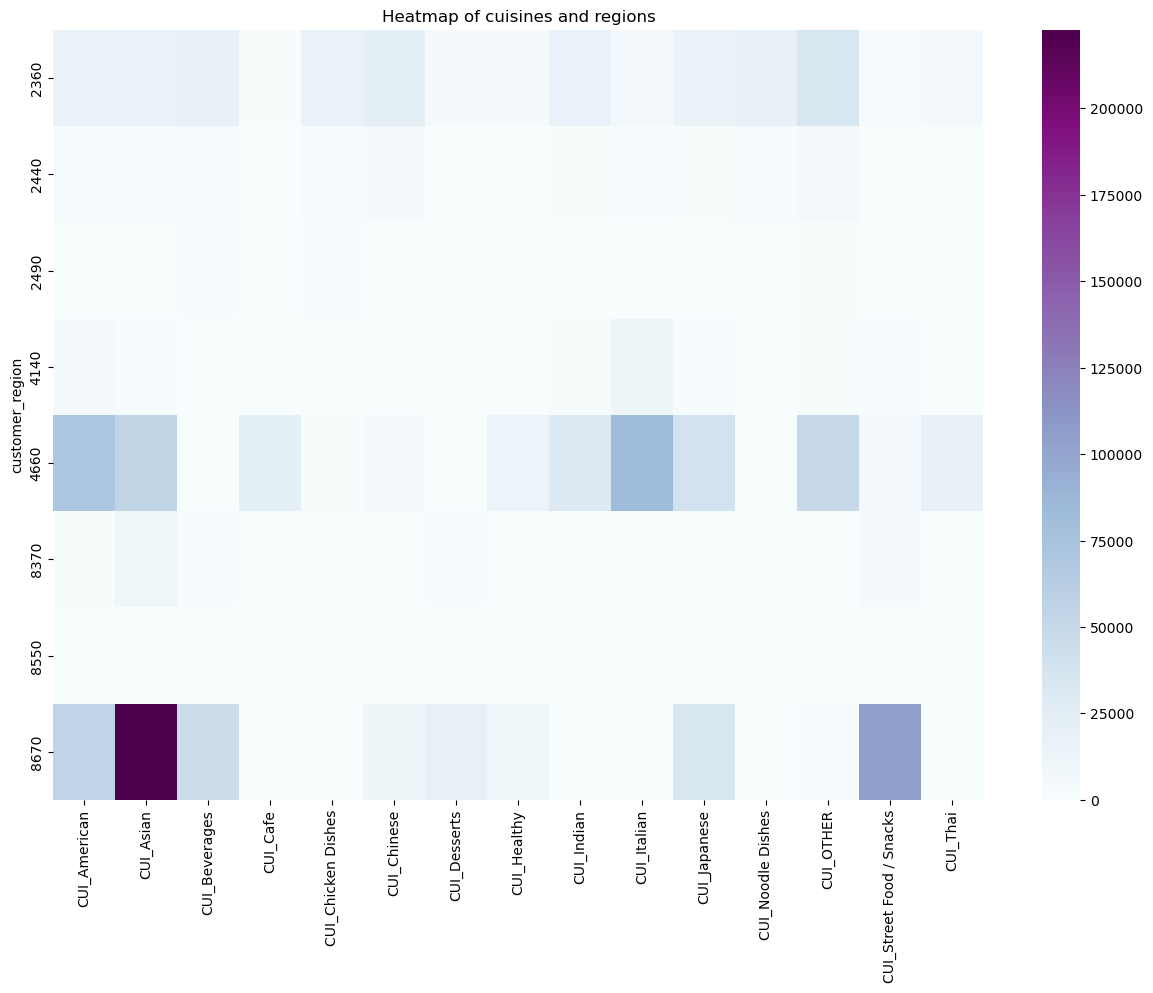

In [116]:
# make a heatmap of cuisines and region
df_region = df.groupby('customer_region')[CUI_col].sum()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_region, cmap= 'BuPu', ax=ax)
plt.title('Heatmap of cuisines and regions')
plt.show()

#### different approach

In [128]:
# Plot the radar plot for every region and CUI_col in a grid 3x3
regions = df["customer_region"].dropna().unique()

fig = make_subplots(rows=3, cols=3, specs=[[{'type': 'polar'}]*3]*3, subplot_titles=[f'Region {region}' for region in regions])
#adjust the space between the radar charts
fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 1000])), showlegend=False)
for i, region in enumerate(regions):
    df_region = df[df["customer_region"] == region]
    total = df_region[CUI_col].sum(axis=0)
    
    CUI_col_sum = df_region[CUI_col].sum(axis=0)
    CUI_col_sum.sort_values(ascending=True, inplace=True)
    CUI_cumperc = CUI_col_sum.cumsum()/CUI_col_sum.sum()
    CUI_cumperc = CUI_cumperc[CUI_cumperc > 0.30]
    CUI_cumperc = CUI_cumperc.index
    
    theta = total.index
    count = 1
    new_theta = []
    for t in theta:
        if t in CUI_cumperc:
            new_theta.append(t)
        else:
            new_theta.append(' ' * count)
            count += 1
    theta = new_theta

    radar = pd.DataFrame(dict(r=total, theta= theta))
    fig.add_trace(px.line_polar(radar, r='r', theta='theta', line_close=True).data[0], row=(i//3)+1, col=(i%3)+1)
    #change the lbel of the radar chart

# Update annotations to adjust the subplot title positions
for annotation in fig['layout']['annotations']:
    annotation['y'] = annotation['y'] + 0.05  # Adjust this value to move the titles up or down


fig.update_layout(title_y=0.99,height=900, width=900, title_text="Radar Charts for Each Region")
fig.show()








In [129]:
regions = df["customer_region"].dropna().unique()

for region in regions:
    df_region = df[df["customer_region"] == region]
    total = df_region[CUI_col].sum(axis = 0)
    
    CUI_col_sum = df_region[CUI_col].sum(axis=0)
    CUI_col_sum.sort_values(ascending=True, inplace=True)
    CUI_cumperc = CUI_col_sum.cumsum()/CUI_col_sum.sum()
    CUI_cumperc = CUI_cumperc[CUI_cumperc > 0.30]
    CUI_cumperc = CUI_cumperc.index
    
    theta = total.index
    count = 1
    new_theta = []
    for t in theta:
        if t in CUI_cumperc:
            new_theta.append(t)
        else:
            new_theta.append(' ' * count)
            count += 1
    theta = new_theta    
    
    radar = pd.DataFrame(dict(r=total, theta=theta))
    fig = px.line_polar(radar, r='r', theta='theta', line_close=True)
    fig.update_layout(title=f'Region {region} Radar Chart')
    fig.show()


## CUI by DOW

In [ ]:
# make a heatmap of cuisines and region
df_region = df.groupby('customer_region')[CUI_col].sum()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_region, cmap= 'BuPu', ax=ax)
plt.title('Heatmap of cuisines and regions')
plt.show()